# Rasterize ICESat-2

In [1]:
import argparse
import rioxarray as rxr
import xarray as xr
import pandas as pd
import os
import glob
from shapely import wkt
from shapely.geometry import Polygon, LineString, MultiPolygon, Point
import geopandas as gpd
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import seaborn as sns
import rasterio as rio

In [2]:
data_path = '/Users/raineyaberle/Research/PhD/Hubbard/surface_elevation/ICESat-2/'
data_fns = [os.path.basename(x) for x in sorted(glob.glob(os.path.join(data_path, 'CSVs', '*.csv')))]
ifsar_path = '/Users/raineyaberle/Research/PhD/Hubbard/surface_elevation/'
ifsar_fn = 'ifsar_hubbardDEM.tif'
out_path = os.path.join(data_path, 'rasters')
figure_out_path = os.path.join(data_path, 'figures')

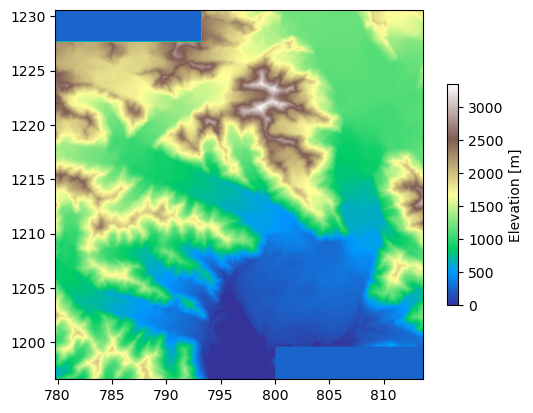

In [3]:
# Load IFSAR DEM
ifsar = rxr.open_rasterio(os.path.join(ifsar_path, ifsar_fn))
ifsar_extent_poly = Polygon([[np.min(ifsar.x.data), np.min(ifsar.y.data)],
                                 [np.max(ifsar.x.data), np.min(ifsar.y.data)],
                                 [np.max(ifsar.x.data), np.max(ifsar.y.data)],
                                 [np.min(ifsar.x.data), np.max(ifsar.y.data)],
                                 [np.min(ifsar.x.data), np.min(ifsar.y.data)]])
plt.imshow(ifsar.data[0], cmap='terrain', 
           extent=(np.min(ifsar.x.data)/1e3, np.max(ifsar.x.data)/1e3, 
                   np.min(ifsar.y.data)/1e3, np.max(ifsar.y.data)/1e3))
plt.colorbar(shrink=0.6, label='Elevation [m]')
plt.show()

In [ ]:
# -----Define some functions
def load_is2_csv(data_path, data_fn, out_crs):
    # Load CSV
    is2_df = pd.read_csv(os.path.join(data_path, 'CSVs', data_fn))
    # Interpret geometry column
    is2_df['geometry'] = is2_df['geometry'].apply(wkt.loads)
    # Convert to GeoDataFrame
    is2_gdf = gpd.GeoDataFrame(is2_df, geometry='geometry', crs='EPSG:4326')
    # Reproject to out_crs
    is2_gdf = is2_gdf.to_crs(out_crs)
    # Add x and y columns to ICESat-2 gdf
    is2_gdf['x'] = is2_gdf.geometry.x
    is2_gdf['y'] = is2_gdf.geometry.y

    return is2_gdf    
    
def create_footprint_polygons(points):
    # Calculate the direction of the line
    line_direction = np.arctan2(points[-1].y - points[0].y, points[-1].x - points[0].x)
    
    # Compute vectors representing the offset of each point
    cos_theta = np.cos(line_direction)
    sin_theta = np.sin(line_direction)
    offset_vectors = np.array([[-5.5 * sin_theta - 10 * cos_theta, 5.5 * cos_theta - 10 * sin_theta], 
                               [5.5 * sin_theta - 10 * cos_theta, -5.5 * cos_theta - 10 * sin_theta],
                               [5.5 * sin_theta + 10 * cos_theta, -5.5 * cos_theta + 10 * sin_theta],
                               [-5.5 * sin_theta + 10 * cos_theta, 5.5 * cos_theta + 10 * sin_theta]])
    
    footprint_polygons = []
    
    # Generate polygons from the calculated points
    for point in points:
        polygon_points = []
        for offset_vector in offset_vectors:
            polygon_points.append(Point(point.x + offset_vector[0], point.y + offset_vector[1]))
        # Close the polygon by adding the first point again
        polygon_points.append(polygon_points[0])
        footprint_polygons.append(Polygon(polygon_points))
    
    return footprint_polygons



In [ ]:
# -----Iterate over ICESat-2 data files
for data_fn in data_fns:
    # Grab date from file name
    date = data_fn[0:10]
    
    # Load and adjust CSV
    is2_gdf = load_is2_csv(data_path, data_fn, out_crs=ifsar.rio.crs)

    # Check for coverage over IFSAR area
    if all(is2_gdf.within(ifsar_extent_poly).values)==False:
        print('No ICESat-2 coverage over IFSAR grid, skipping...')
        continue
    
    # Intialize list of polygons
    all_polys = []
    
    # Iterate over unique ground tracks
    for i, gt in enumerate(is2_gdf['gt'].unique()):
        is2_gdf_gt = is2_gdf.loc[is2_gdf['gt']==gt]
        # Convert point geometries to polygons according to footprint
        points = is2_gdf_gt['geometry'].values
        polys = create_footprint_polygons(points)
        all_polys += polys
        if i==0:
            all_values = is2_gdf_gt['h_mean'].values
        else:
            all_values = np.concatenate([all_values, is2_gdf_gt['h_mean'].values])
    # Rasterize list of polygons to IFSAR grid
    shapes = ((geom,value) for geom, value in zip(all_polys, all_values))
    is2_raster = rio.features.rasterize(shapes, 
                                        out_shape=np.shape(ifsar.data[0]), 
                                        fill=np.nan,
                                        all_touched=True,
                                        transform=ifsar.rio.transform())

    # Convert heights to xarray.Dataset
    h_xds = xr.Dataset(data_vars=dict(h_mean=(["y", "x"], is2_raster)), 
                       coords=dict(x=(["x"], ifsar.x.data), y=(["y"], ifsar.y.data)), 
                       attrs=dict(description="Rasterized ICESat-2 ATL06 mean surface heights", date=str(date)))

    # Save to file
    out_fn = data_fn.replace('.csv', '.tif')
    h_xds.rio.to_raster(os.path.join(data_path, out_fn))
    print('Raster saved to file:', os.path.join(out_path, out_fn))
    
    
    # Plot raster
    # fig, ax = plt.subplots(1, 2, figsize=(10,6))
    # ax[0].imshow(ifsar.data[0], extent=(np.min(ifsar.x.data), np.max(ifsar.x.data), 
    #                                     np.min(ifsar.y.data), np.max(ifsar.y.data)))
    # ax[0].plot(is2_gdf['x'], is2_gdf['y'], '.m')
    # ax[1].imshow(is2_raster_array, extent=(np.min(ifsar.x.data), np.max(ifsar.x.data), 
    #                                        np.min(ifsar.y.data), np.max(ifsar.y.data)))
    # fig.suptitle(date)
    # plt.show()
    # print(f'Unique values: {np.unique(is2_raster)}')